***Exercise 9-1***

In [1]:
# Import needed libraries
import numpy as np
import random
import thinkstats2
import thinkplot

In [3]:
# Copy over classes & functions from book

class HypothesisTest(object):

    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)

    def PValue(self, iters=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, data):
        raise UnimplementedMethodException()

    def MakeModel(self):
        pass

    def RunModel(self):
        raise UnimplementedMethodException()
        
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

class DiffMeansOneSided(DiffMeansPermute):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.mean() - group2.mean()
        return test_stat
    
class DiffStdPermute(DiffMeansPermute):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.std() - group2.std()
        return test_stat
    
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys
    
class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat
    
def FalseNegRate(data, num_runs=1000):

    group1, group2 = data
    count = 0

    for i in range(num_runs):
        sample1 = thinkstats2.Resample(group1)
        sample2 = thinkstats2.Resample(group2)
        ht = DiffMeansPermute((sample1, sample2))
        p_value = ht.PValue(iters=101)
        if p_value > 0.05:
            count += 1

    return count / num_runs

In [38]:
# Import the data and convert into data frames
import first
live, firsts, others = first.MakeFrames()

In [88]:
# Create a samples from the data frames
firsts_sample = thinkstats2.SampleRows(firsts, 540, replace=False)
others_sample = thinkstats2.SampleRows(others, 540, replace=False)

In [89]:
# Create the variable data to run the tests
data = firsts_sample.prglngth.values, others_sample.prglngth.values

In [92]:
# Test the difference in mean pregnancy length (two-sided)
ht = DiffMeansPermute(data)
pvalue = ht.PValue()
pvalue

0.724

In [93]:
# Test the difference in mean pregnancy length (one-sided)
ht = DiffMeansOneSided(data)
pvalue = ht.PValue()
pvalue

0.385

In [94]:
# Test the difference in standard deviation of pregnancy lengths
ht = DiffStdPermute(data)
pvalue = ht.PValue()
pvalue

0.377

In [115]:
# Create the sample data to be used for correlation testing
cleaned = live.dropna(subset=['agepreg', 'totalwgt_lb'])
cleaned_sample = thinkstats2.SampleRows(cleaned, 2000, replace=False)
data = cleaned_sample.agepreg.values, cleaned_sample.totalwgt_lb.values

In [116]:
# Test the correlation between birth weight and mother's age 
ht = CorrelationPermute(data)
pvalue = ht.PValue()
pvalue

0.0

In [23]:
# Compare the actual correlation statistic to the largest value in the simulations
ht.actual, ht.MaxTestStat()

(0.10253325933238923, 0.07544998486312128)

In [90]:
# Use Chi-square test to test the deviation of first babies and others from the expected number of births in each 
# week of pregnancy
data = firsts_sample.prglngth.values, others_sample.prglngth.values
ht = PregLengthTest(data)
p_value = ht.PValue()
print('p-value =', p_value)
print('actual =', ht.actual)
print('ts max =', ht.MaxTestStat())

p-value = 0.047
actual = 15.654938058784941
ts max = 24.852503714924133


In [25]:
# Check the false negative rate (the power)
neg_rate = FalseNegRate(data)
neg_rate

0.944

**Exercise:** As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use `thinkstats2.SampleRows` to select a random subset of the rows in a DataFrame.

What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

In [24]:
# My first time through, i reduced the sample to 2000 from over 4000 observations. There wasn't a dramatic effect in 
# the values at that point, but I kept running the test with less and less observations in the sample and the p-values 
# get larger indicating less significant findings. Through trial and error, i found that a sample size of approximately 540, still 
# yields a positive chi-square test. For correlation p-values, i found that as I reduced sample size my results varied so
# drastically even with the same sample size. One test with 2000 observations, yielded 0.0 corr p-value and the next with 
# 2000 observations would yield 0.25 corr p-value.

***Exercise 10-1***

In [1]:
# Import needed libraries
import numpy as np
import random
import thinkstats2
import thinkplot
import brfss
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

In [2]:
# Copy over the functions from the book

def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)

    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx

    return inter, slope

def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res

def PlotPercentiles(hgt_means, cdfs):
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(hgt_means, weight_percentiles, label=label)
        
def SampleRows(df, nrows, replace=False):
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

def ResampleRows(df):
    return SampleRows(df, len(df), replace=True)

def SamplingDistributions(df, iters=101):
    t = []
    for _ in range(iters):
        sample = ResampleRows(df)
        heights = sample.htm3
        weights = sample.wtkg2
        log_weights = np.log10(weights)
        estimates = LeastSquares(heights, log_weights)
        t.append(estimates)
    inters, slopes = zip(*t)
    return inters, slopes

def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)
    
def PlotConfidenceIntervals(xs, inters, slopes, percent=90, **options):
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = FitLine(xs, inter, slope)
        fys_seq.append(fys)

    p = (100 - percent) / 2
    percents = p, 100 - p
    low, high = thinkstats2.PercentileRows(fys_seq, percents)
    thinkplot.FillBetween(fxs, low, high, **options)
    
def CoefDetermination(ys, res):
    return 1 - Var(res) / Var(ys)

class SlopeTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        ages, weights = data
        _, slope = thinkstats2.LeastSquares(ages, weights)
        return slope

    def MakeModel(self):
        _, weights = self.data
        self.ybar = weights.mean()
        self.res = weights - self.ybar

    def RunModel(self):
        ages, _ = self.data
        weights = self.ybar + np.random.permutation(self.res)
        return ages, weights
    
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

In [4]:
# Read in the data from the Brfss to look at the statistics for log_weight versus height
df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

In [32]:
# Estimate intercept and slope using the LeastSquares function
inter, slope = LeastSquares(heights, log_weights)
inter, slope

(0.9930804163918066, 0.005281454169417841)

In [33]:
# Calculate the fitted line in order to plot it
fit_xs, fit_ys = FitLine(heights, inter, slope)

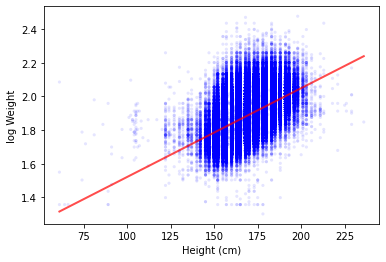

In [21]:
# Make a scatter plot of the data and show the fitted line
thinkplot.Scatter(heights, log_weights, color='blue', alpha=0.1, s=10)
thinkplot.Plot(fit_xs, fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="Height (cm)",
                 ylabel='log Weight',
                 legend=False)

In [ ]:
# Not sure why the slope in the least squares calculation was 0.005, but in the image it appears to be quite a bit more.

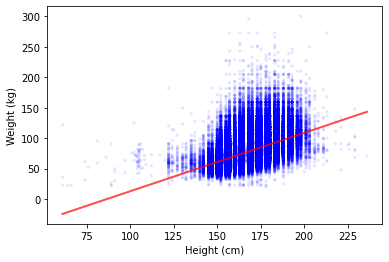

In [23]:
# Make the same plot but apply the inverse transform to show weights on a linear (not log) scale.
inter, slope = LeastSquares(heights, weights)
fit_xs, fit_ys = FitLine(heights, inter, slope)

thinkplot.Scatter(heights, weights, color='blue', alpha=0.1, s=10)
thinkplot.Plot(fit_xs, fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="Height (cm)",
                 ylabel='Weight (kg)',
                 legend=False)

In [34]:
# Plot percentiles of the residuals, first create residual column in df
df['residual'] = Residuals(heights, log_weights, inter, slope)

In [35]:
# Separate the data into groups
bins = np.arange(125, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

In [36]:
# Compute the means and cdfs of the residuals for each group
hgt_means = [group.htm3.mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for _, group in groups][1:-1]

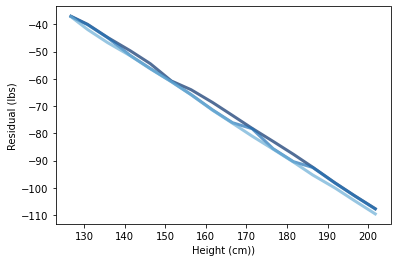

In [28]:
# Plot percentiles
PlotPercentiles(hgt_means, cdfs)

thinkplot.Config(xlabel="Height (cm))",
                 ylabel='Residual weight (lbs)')

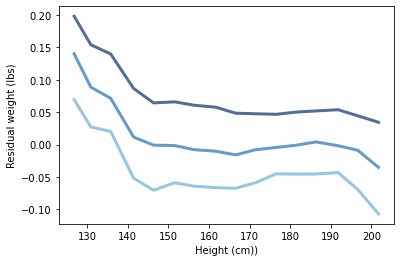

In [37]:
# Had to investigate what happened there. Turns out the function was written specifically for the book example, 
# so I had to make some changes to the function and I will try it again. 
PlotPercentiles(hgt_means, cdfs)

thinkplot.Config(xlabel="Height (cm))",
                 ylabel='Residual weight (lbs)')

In [38]:
# Compute correlation
rho = thinkstats2.Corr(heights, log_weights)
rho

0.5317282605983464

In [39]:
# Compute coefficient of determination
r2 = thinkstats2.CoefDetermination(log_weights, res)
r2

NameError: name 'res' is not defined

In [40]:
# Whoops, guess I gotta go back and calculate the residuals first and save them to res to make that work
res = Residuals(heights, log_weights, inter, slope)
r2 = thinkstats2.CoefDetermination(log_weights, res)
r2

0.28273494311893543

In [42]:
# Confirm that  𝑅2=𝜌2. I have no idea why my calculation for this is so diffent from the solution listed?? But they 
# are both really really small numbers, so they are nearly the same.
rho**2 - r2

7.605027718682322e-15

In [49]:
# Compute Std(ys), which is the RMSE of predictions that don't use height
std_ys = thinkstats2.Std(log_weights)
std_ys

0.10320725030004854

In [50]:
# Compute Std(res), the RMSE of predictions that do use height.
std_res = thinkstats2.Std(res)
std_res

0.08740777080416082

In [51]:
# How much does height information reduce RMSE?
1 - std_res / std_ys

0.15308497658793152

In [61]:
# Use resampling to compute sampling distributions for inter and slope. This time I was smart enough to go back 
# and alter the function before it fails.
sample_inters, sample_slopes = SamplingDistributions(df, iters=101)

{'xscale': 'linear', 'yscale': 'linear'}

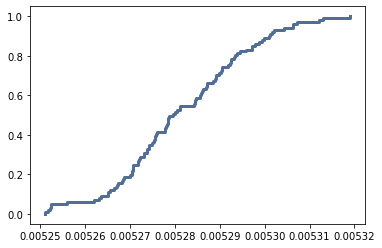

In [62]:
# Plot the sampling distribution of slope
cdf = thinkstats2.Cdf(sample_slopes)
thinkplot.Cdf(cdf)

In [63]:
# Compute the p-value of the slope
pvalue = cdf[0]
pvalue

0

In [68]:
# Use the Summarize function to calculate mean, standard deviation, and confidence intervals of the sample slopes
Summarize(sample_slopes)

mean, SE, CI 0.005281490670549738 1.4462554328347843e-05 (0.005255982637295625, 0.005306311046341193)


In [5]:
# Resample rows without weights, compute mean height, and summarize results
unweighted = [ResampleRows(df).htm3.mean() for _ in range(100)]
Summarize(unweighted)

mean, SE, CI 168.95562842316943 0.016089560338696504 (168.92646880494755, 168.97970856322885)


In [11]:
# I have to read in the dataframe with the additional column to be able to resample rows with weights
df2 = df.dropna(subset=['htm3', 'wtkg2', 'finalwt'])
heights, weights, finalwt = df2.htm3, df2.wtkg2, df2.finalwt

In [12]:
# Resample rows with weights. Note that the weight column in this dataset is called finalwt
weighted = [ResampleRowsWeighted(df2, 'finalwt').htm3.mean() for _ in range(100)]
Summarize(weighted)

mean, SE, CI 170.4976934659148 0.01717508574139788 (170.46895652701147, 170.52319165706663)


In [ ]:
# The difference between the means with and without weights is approximately 1.54 centimeters, this is substantially
# higher than the standard error of the estimate at 0.016 centimeters, which implies that the difference is not
# due to chance.